In [1]:
import pandas as pd    
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB # Naive Bayes
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# 1. Data Exploration

In [3]:
disney = pd.read_csv("subreddit_DisneyPlus_data.csv")
netflix = pd.read_csv("subreddit_netflix_data.csv")

In [4]:
disney.head()

,title,score,id,url,comms_num,created,body
0,Monthly Tech Support & Missing Content Thread,2,1ggy19d,https://www.reddit.com/r/DisneyPlus/comments/1...,39,2024-11-01 12:01:37,All posts regarding tech support or missing co...
1,The Simpsons: Treehouse of Horror XXXV - now s...,60,1gkbwwp,https://i.redd.it/xwpcgk4n94zd1.jpeg,12,2024-11-06 00:18:57,NaN
2,What do you think of Bolt?,7,1gpfceh,https://i.redd.it/m4dgy1b8af0e1.jpeg,1,2024-11-12 14:25:35,I think this movie deserves a lot of attention...
3,New official poster for 'What If...?' Season 3,84,1goxum0,https://i.redd.it/yc5mfxwk5b0e1.jpeg,21,2024-11-12 00:32:33,NaN
4,‘High Potential’ Premiere Draws Over 20 Millio...,11,1gpayc9,https://www.thewrap.com/high-potential-premier...,1,2024-11-12 09:58:42,NaN


In [5]:
netflix.head()

,title,score,id,url,comms_num,created,body
0,/r/Netflix Discord Server,476,mxm3re,https://www.reddit.com/r/netflix/comments/mxm3...,249,2021-04-24 22:24:04,We are pleased to announce we have affiliated ...
1,Enough Mark Wahlberg!,235,1gpas31,https://www.reddit.com/r/netflix/comments/1gpa...,63,2024-11-12 09:49:41,He plays the same character in every movie! He...
2,Windows lagging?,66,1gp72oi,https://www.reddit.com/r/netflix/comments/1gp7...,84,2024-11-12 06:50:30,Just a quick question \nIs anyone elses netfli...
3,No Netflix interface when watching on PC?,34,1gp75y3,https://www.reddit.com/r/netflix/comments/1gp7...,22,2024-11-12 06:54:45,"As said in the title, what happened to the int..."
4,Netflix broken?,22,1gp7n93,https://www.reddit.com/r/netflix/comments/1gp7...,12,2024-11-12 07:17:00,"So, I'm assuming netflix is broken for everyon..."


In [6]:
netflix.isnull().sum()

title          0
score          0
id             0
url            0
comms_num      0
created        0
body         128
dtype: int64

In [7]:
netflix.describe()

,score,comms_num
count,535.000000,535.000000
mean,33.841121,19.351402
std,123.536947,61.995740
min,0.000000,0.000000
25%,0.000000,1.000000
50%,3.000000,4.000000
75%,11.500000,11.500000
max,1656.000000,932.000000


In [8]:
disney.isnull().sum()

title          0
score          0
id             0
url            0
comms_num      0
created        0
body         262
dtype: int64

In [9]:
disney.describe()

,score,comms_num
count,930.000000,930.000000
mean,42.958065,20.097849
std,131.545379,47.999687
min,0.000000,0.000000
25%,3.000000,2.000000
50%,8.000000,7.000000
75%,26.000000,18.000000
max,1751.000000,590.000000


# 2. Data Cleaning

In [11]:
# Drop unused columns ['id','url','created']
netflix = netflix.drop(columns=['id','url','created','body'])
disney = disney.drop(columns=['id','url','created','body'])

In [12]:
# Check the shape
netflix.shape, disney.shape

((535, 3), (930, 3))

In [13]:
# Add platform column 
# Netflix = 1
# Disney+ Hotstar = 0
netflix.insert(1, "platform","netflix")
disney.insert(1,"platform","disney")

In [14]:
df = pd.concat([netflix,disney],axis=0)

In [15]:
df.isnull().sum()

title        0
platform     0
score        0
comms_num    0
dtype: int64

# 3. EDA

## 3.1 Score and The Number of Comments

In [18]:
print("The Correlation between Score and Number of Comments")
print(f" Overall: {df['score'].corr(df['comms_num']).round(4)}")
print(f" Netflix: {netflix['score'].corr(netflix['comms_num']).round(4)}")
print(f" Disney+: {disney['score'].corr(disney['comms_num']).round(4)}")

The Correlation between Score and Number of Comments
 Overall: 0.6689
 Netflix: 0.6477
 Disney+: 0.698


<Axes: xlabel='score', ylabel='comms_num'>

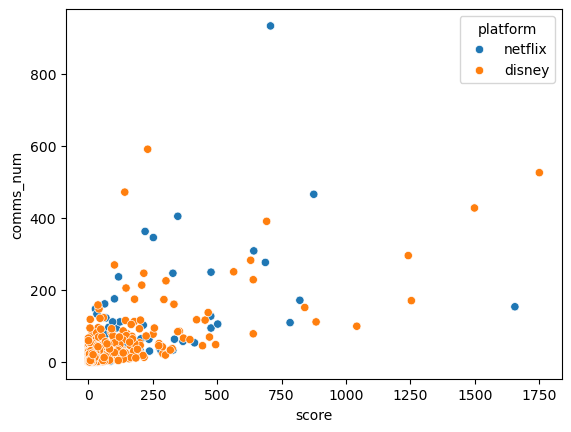

In [19]:
sns.scatterplot(df,x = 'score', y = 'comms_num',hue='platform')

### Score

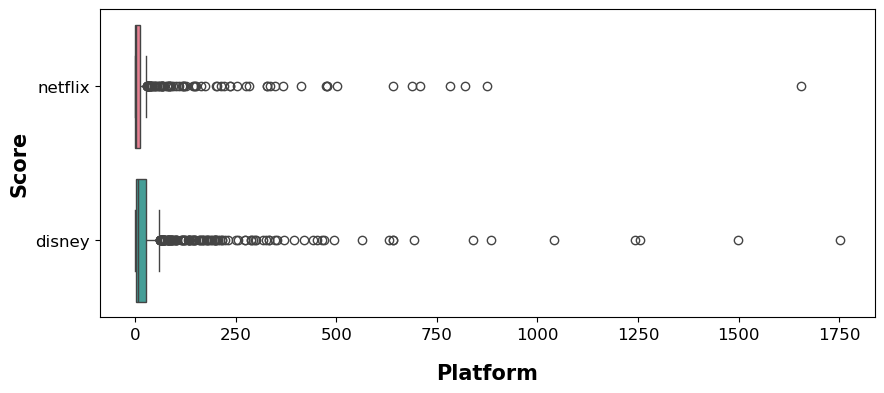

In [21]:
# Speard of the number of comments of  Platform
comms_num = plt.figure(figsize=(10,4))
sns.boxplot( x = 'score',y = 'platform', data = df, hue = 'platform', palette = 'husl');
plt.xlabel('Platform', fontsize=15, fontweight="bold",labelpad=15)
plt.xticks(fontsize= 12) 
plt.ylabel('Score', fontsize=15, fontweight="bold")
plt.yticks(fontsize= 12);

In [22]:
# Looking at The outliners > the title with more than 750 score
df[df['platform']=='netflix'].sort_values(by='score',ascending=False)['title'].head(4).array

<NumpyExtensionArray>
['I just rewatched Mindhunter. What a colossal blunder to let Fincher walk.',
     'Menendez brothers were molested and should walk free, says prosecutor',
                                    'The need for growth is ruining Netflix',
                    "The Queen's Gambit debuted 4 yrs ago today on Netflix."]
Length: 4, dtype: object

In [23]:
# Looking at The outliners > the title with more than 750 score
df[df['platform']=='disney'].sort_values(by='score',ascending=False)['title'].head(7).array

<NumpyExtensionArray>
[                                                                                                                          '???',
                                                                                                          'That’s just obscene ',
                               "'Agatha All Along' Falls Out of Top 10 Streaming Shows Last Week Despite Significant Plot Twist",
                                                                                                        'Children’s PG profile ',
                                                                                           'Not sure I can afford it anymore...',
                                                                                       'Phineas and Ferb Revival - First Poster',
 'Disney+ has just removed all the Indiana Jones movies directed by Steven Spielberg from the platform worldwide.\n\n\n\n\n\n\n']
Length: 7, dtype: object

### The Number of Comments

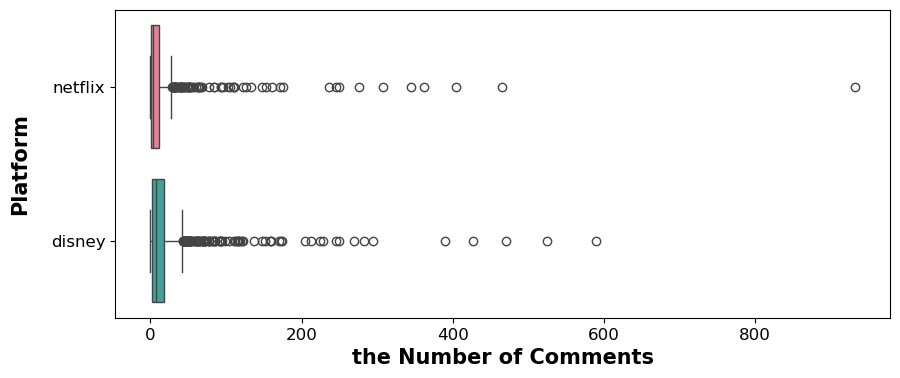

In [25]:
# Speard of the number of comments of each Platform
comms_num = plt.figure(figsize=(10,4))
sns.boxplot( x = 'comms_num',y = 'platform', data = df, hue = 'platform', palette = 'husl');
plt.ylabel('Platform', fontsize=15, fontweight="bold",labelpad=15)
plt.yticks(fontsize= 12) 
plt.xlabel('the Number of Comments', fontsize=15, fontweight="bold")
plt.xticks(fontsize= 12);

In [29]:
# Looking at The outliners (Top5)
df[df['platform']=='netflix'].sort_values(by='comms_num',ascending=False)['title'].head(5).array

<NumpyExtensionArray>
[                    'Outer banks new season has crippling audio issues',
 'Menendez brothers were molested and should walk free, says prosecutor',
                                     'Sweet Bobby: My Catfish Nightmare',
      'Just finished Alien Abduction in Manhattan. I’m on Carol’s side.',
                                        "time cut didn't make any sense"]
Length: 5, dtype: object

In [31]:
# Looking at The outliners (Top5)
df[df['platform']=='disney'].sort_values(by='comms_num',ascending=False)['title'].head(5).array

<NumpyExtensionArray>
[                       'Describe your favorite Disney movie only using emojis👸🦎☀️!',
                                                                               '???',
 "What's a movie everyone keeps insisting is great but you just don't get the hype?",
                                                              'That’s just obscene ',
                          'Disney+ terms prevent allergy death lawsuit, Disney says']
Length: 5, dtype: object